In [9]:
# import standard numerical modules
import numpy as np
import math
import tensorflow as tf

import DCTR


In [15]:
from importlib import reload
reload(DCTR)


<module 'DCTR' from '/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/DCTR.py'>

In [2]:
data_dir = './Data/'


In [3]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair; every event has order: 
# tt-pair, top, anti-top
# every particle has arguments: 
# [pt, y, phi, mass, eta, E, PID, w, theta]
# [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

# POWHEG hvq
# plotting data; different from training data
X0_plt = []
X0_plt = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_converted_lhe.npz', i=3)[:9553938] # 9553938 num of MiNNLO samples
print('POWHEG hvq all particles X0_plt.shape: '+str(X0_plt.shape))

X0_test = []
X0_test = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_normed_converted_lhe.npz', i=3)[:9553938]
print('POWHEG hvq all particles X0_test.shape: '+str(X0_test.shape))



POWHEG hvq all particles X0_plt.shape: (9553938, 3, 9)
POWHEG hvq all particles X0_test.shape: (9553938, 3, 9)


In [4]:
# MiNNLO
# plotting data
X1_plt = []
X1_plt = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_13TeV_NLO/converted_lhe.npz', i=3)
print('MiNNLO all particles X1_plt.shape: '+str(X1_plt.shape))


MiNNLO all particles X1_plt.shape: (9553938, 3, 9)


In [5]:
# get normalized event generator weights

X0_plt_wgt = X0_plt[:, 0, 7].copy()
X0_plt_wgt /= np.mean(X0_plt_wgt) 

X1_plt_wgt = X1_plt[:, 0, 7].copy()
X1_plt_wgt /= np.mean(X1_plt_wgt)


In [6]:
# delete energy
X0_test = np.delete(X0_test, 5, -1)

# delete eta
X0_test = np.delete(X0_test, 4, -1)


In [11]:
import gc # python garbage collection

print(gc.collect())

27894


In [10]:
# save weights to .h5 file
model = './best_model.tf'
dctr = tf.keras.models.load_model(model)
dctr.save('best_model_weights.h5')

# calculate rwgt
with tf.device('CPU'):
    rwgt = DCTR.get_rwgt([model], X0_test) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook

rwgt[0] /= np.mean(rwgt[0]) # adjust so mean is 1



2024-04-05 12:20:28.941948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-05 12:20:28.942337: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-05 12:20:28.942854: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (finn-ThinkPad-T540p): /proc/driver/nvidia/version does not exist
2024-04-05 12:20:28.967174: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 12:20:34.149067: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5732362

In [12]:
# setup args for plotting
args = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
        (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
        (X0_plt, rwgt[0], 'dctr reweighted')]


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


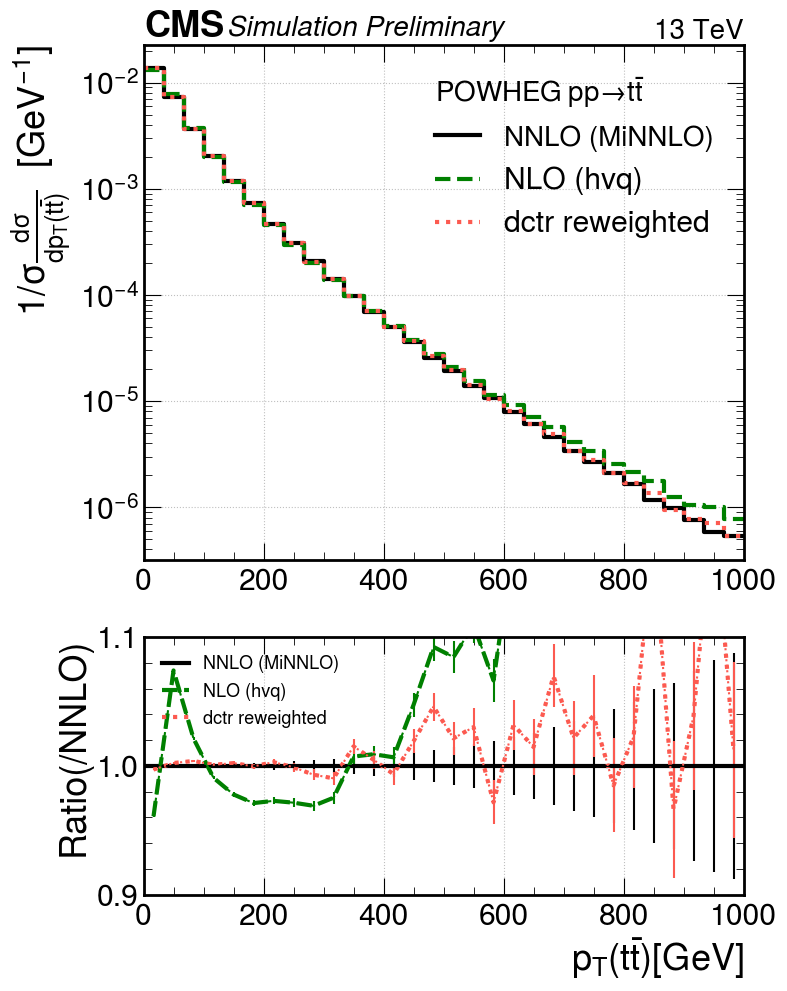

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


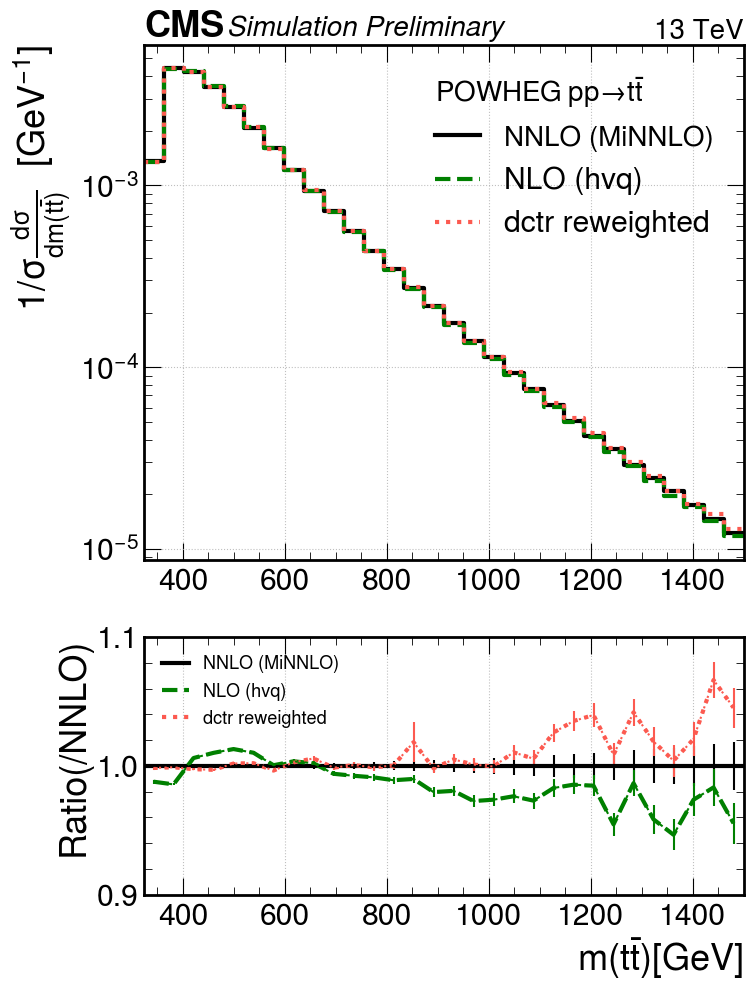

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


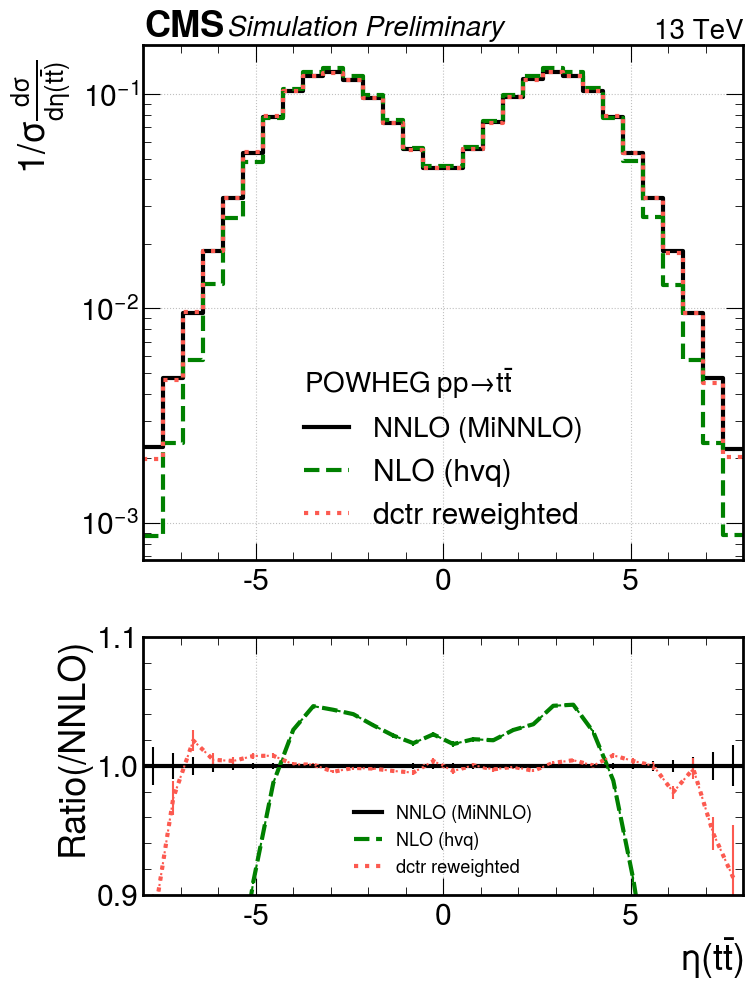

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


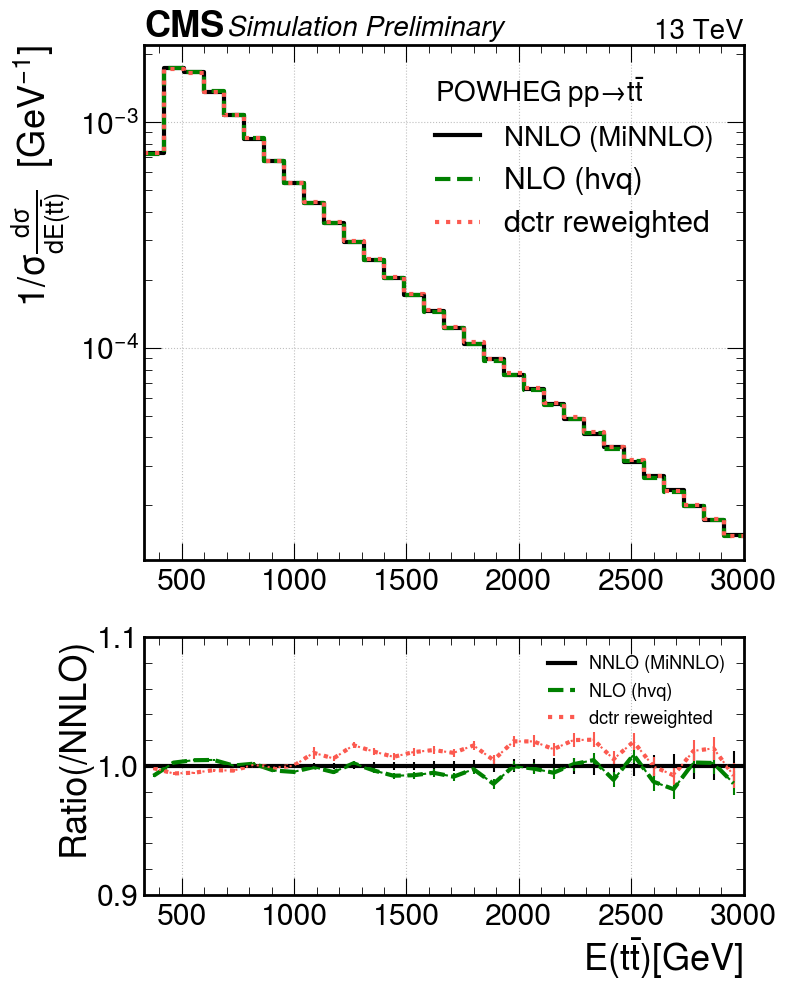

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


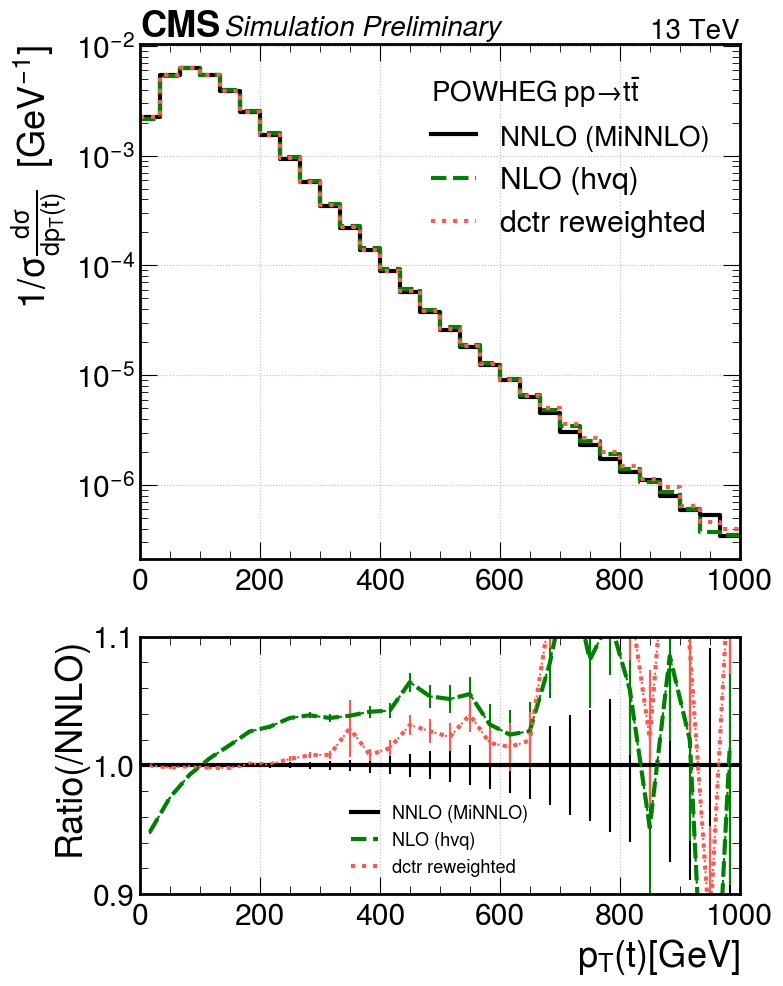

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


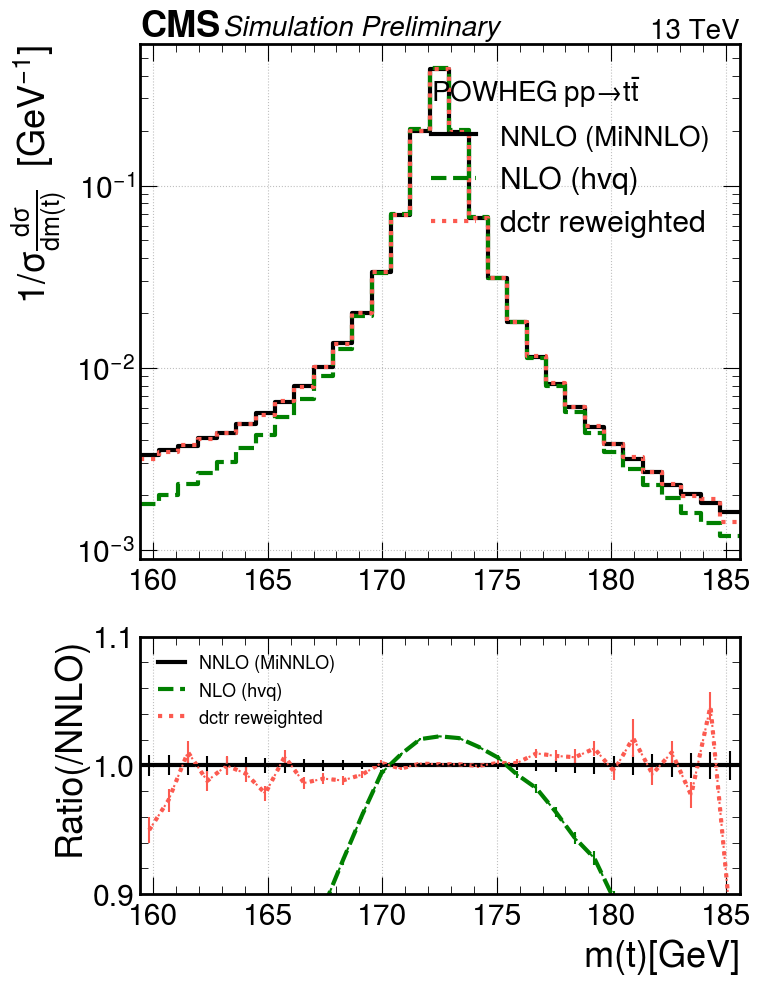

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


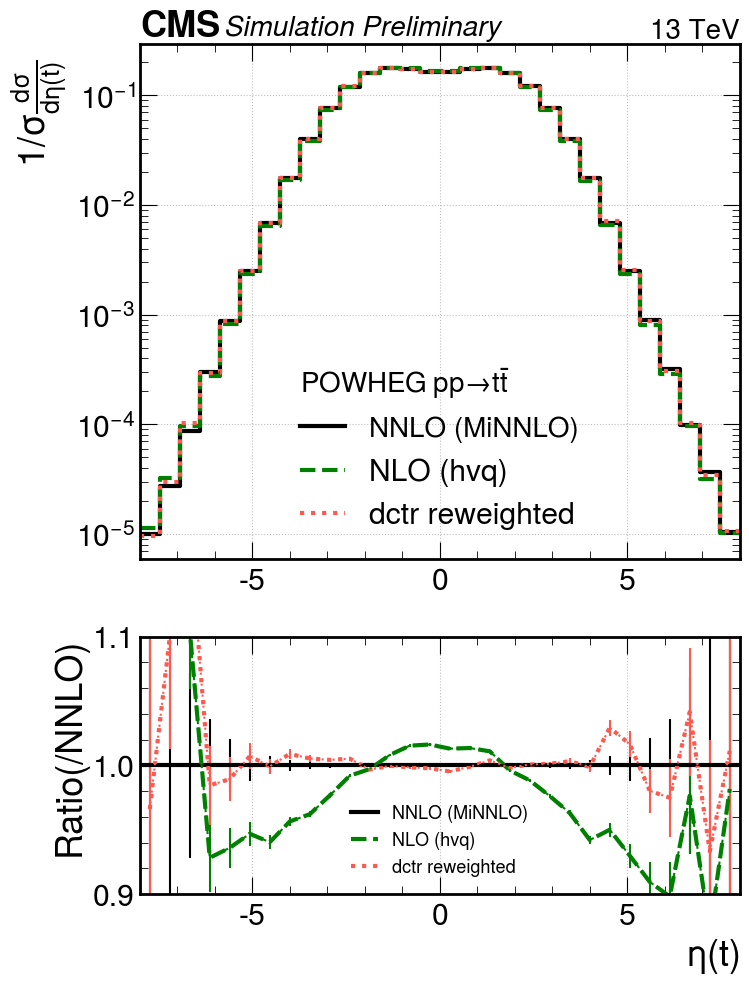

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


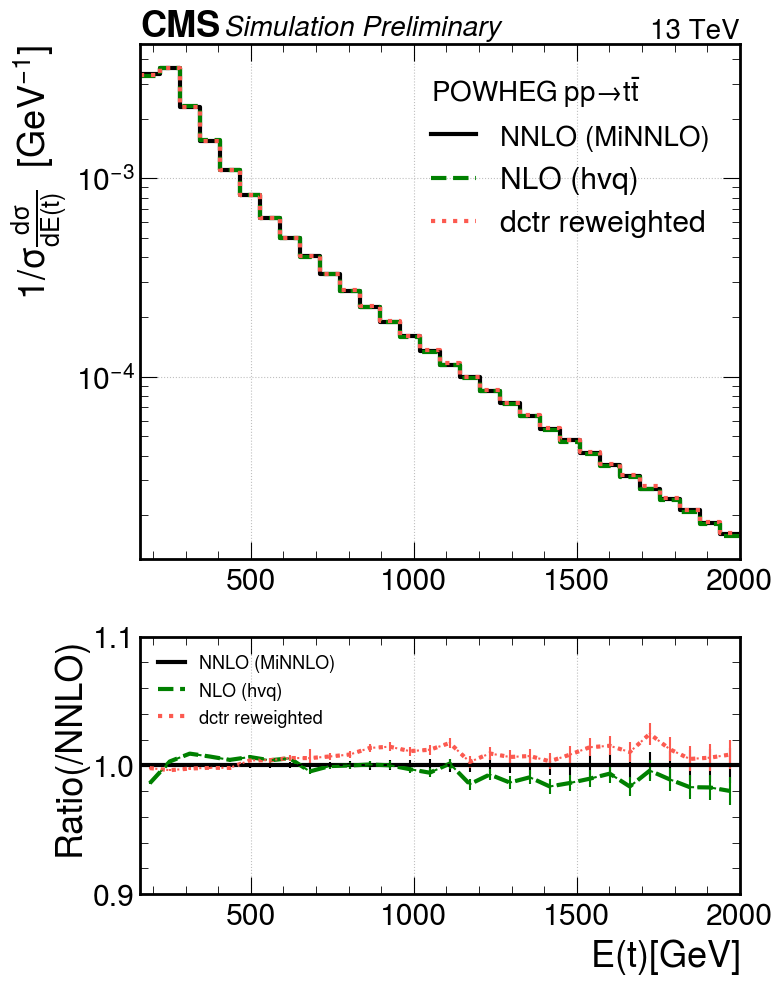

In [18]:
# plotting in CMS style
''' plot_ratio_cms arguments
args, arg_index = 0, part_index = 0, title = None, x_label = None, y_label = None, bins = None, start = None, stop = None, div = 35,
ratio_ylim=[0.9,1.1], pythia_text = pythia_text, figsize=(8,10), y_scale=None, hep_text = 'Simulation Preliminary',
center_mass_energy = '13 TeV', part_label=None, arg_label=None, unit=None, inv_unit=None):

'''

arg_indices = [0, 3, 4, 5]
part_indices = [0, 1]

# plot with proper ranges set for each observable
for part_index in part_indices:
    for arg_index in arg_indices:
        div = 31
        if arg_index == 1:  # rapidity
            start = None
            stop = None
        elif arg_index == 3:  # mass
            if part_index == 0:  # tt-pair
                start = None
                stop = 1500
            else:
                start = None
                stop = None
                div = 32
        elif arg_index == 4:  # pseudorapidity
            start = -8
            stop = 8
        elif arg_index == 5: # energy
            if part_index == 0:  # tt-pair
                start = None
                stop = 3000
            else:
                start = None
                stop = 2000
        else:  # pt
            start = 0
            stop = 1000
        
        DCTR.plot_ratio_cms(args, arg_index=arg_index, part_index=part_index, start=start, stop=stop, div=div, y_scale='log', pythia_text=r'$POWHEG \; pp \to  t\bar{t}$')



'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


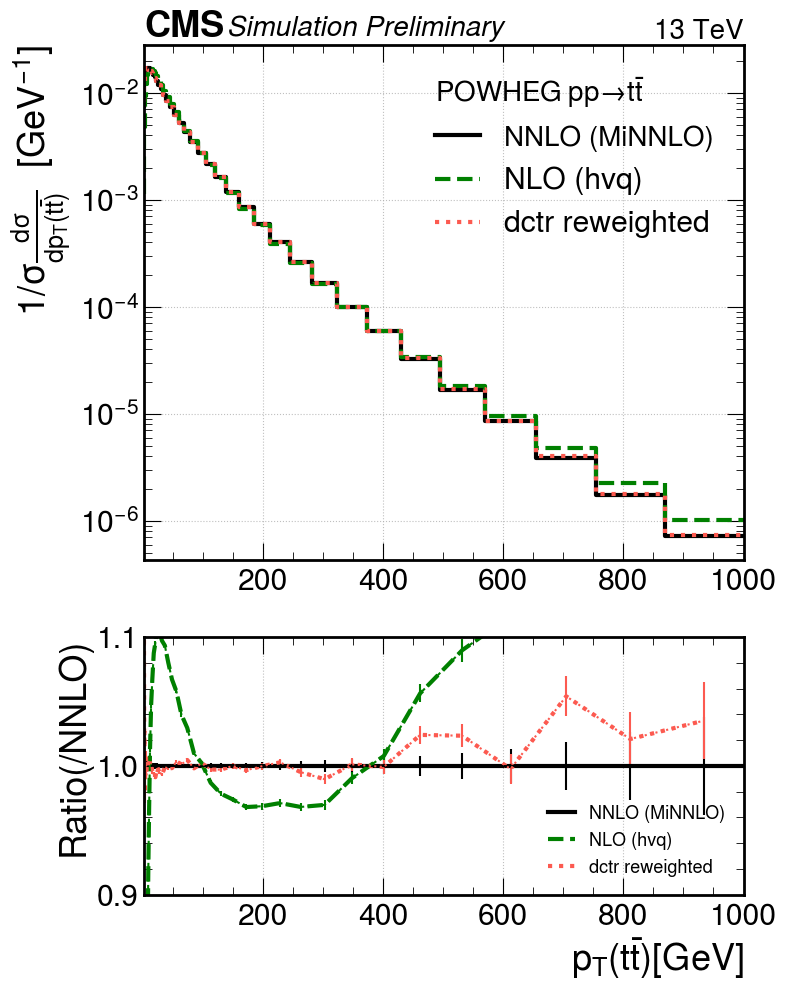

In [16]:
# p_T log binning
log_bins = np.logspace(np.log10(1), np.log10(1e3), 50)

DCTR.plot_ratio_cms(args, arg_index=0, part_index=0, bins=log_bins, y_scale='log') # , ratio_ylim=[0.8, 1.2])



'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


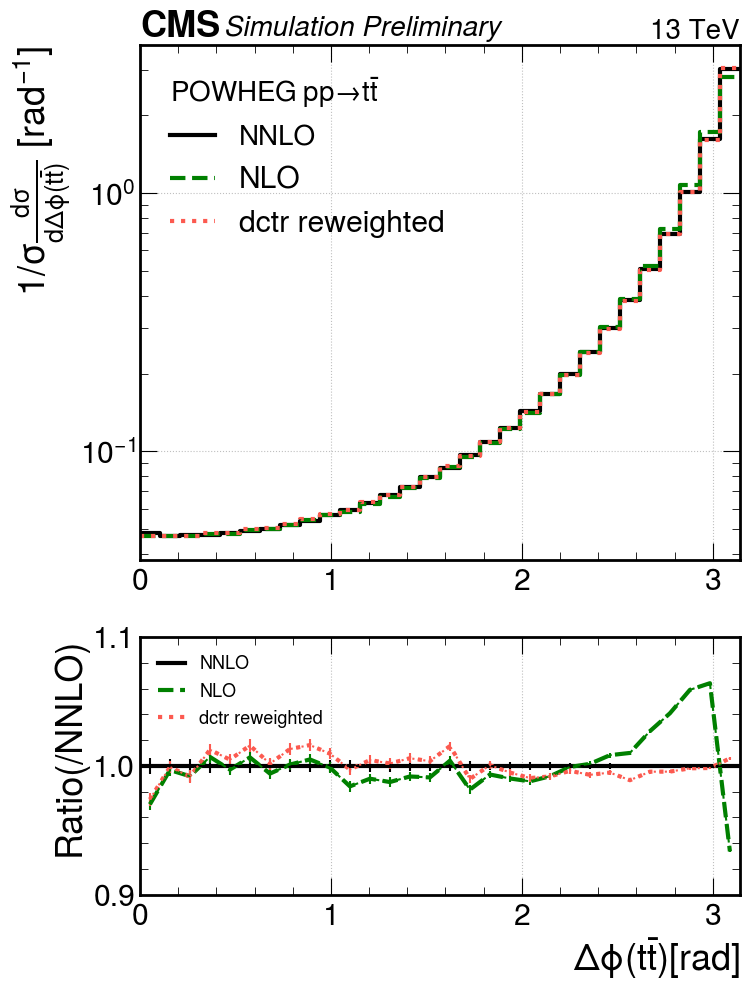

In [17]:
# delta phi
X0_delta_phi = DCTR.delta_phi(X0_plt)
X1_delta_phi = DCTR.delta_phi(X1_plt)

args_delta_phi = [(X1_delta_phi, X1_plt_wgt, 'NNLO'), 
                  (X0_delta_phi, X0_plt_wgt, 'NLO'),
                  (X0_delta_phi, rwgt[0], 'dctr reweighted')]


DCTR.plot_ratio_cms(args_delta_phi, start = 0, stop = math.pi, div=31, part_label=r't \bar{t}', arg_label=r'\Delta \phi', unit='[rad]', inv_unit='[rad$^{-1}$]', y_scale='log')
